# Generate plots for optimal combination workflow

In [1]:
%matplotlib inline
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from glob import glob
import seaborn as sns

In [2]:
# Load data
data_dir = '/Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/'
files = ['p06.SBJ01_S09_Task11_e1.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e2.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e3.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e4.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e5.sm.nii.gz']
files = [op.join(data_dir, f) for f in files]
imgs = [nib.load(f) for f in files]
echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

n_echoes = len(imgs)
n_trs = imgs[0].shape[-1]

pal = sns.color_palette('cubehelix', n_echoes)

In [3]:
# Select voxel from around middle of brain
ts = [img.get_data()[20, 25, 14, :] for img in imgs]

# Prepare data for model
ts_1d = np.hstack(ts) # data raveled out (T * E)
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

# Values for plots
# Values from log-linear model
log_x = np.arange(-80, 0, .01)
log_y = betas[0] + log_x*betas[1]

# Values from monoexponential decay model
mono_x = np.arange(0, 80, .01)
mono_y = np.exp(-1*betas[1]*mono_x) * s0

# Get weights for optimal combination
alpha = echo_times * np.exp(-echo_times / t2s)
alpha = alpha / np.sum(alpha)  # unnecessary but good for bar plot below

# Combine data across echoes
oc = np.average(np.vstack(ts), axis=0, weights=alpha)

## Echo-specific timeseries

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


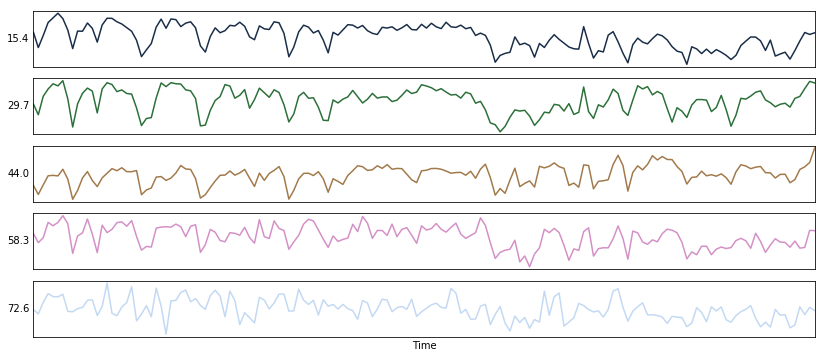

In [4]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(echo_times[i_echo], rotation=0, va='center', labelpad=15)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel('Time')
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.show()

## Echo-specific data and echo time

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


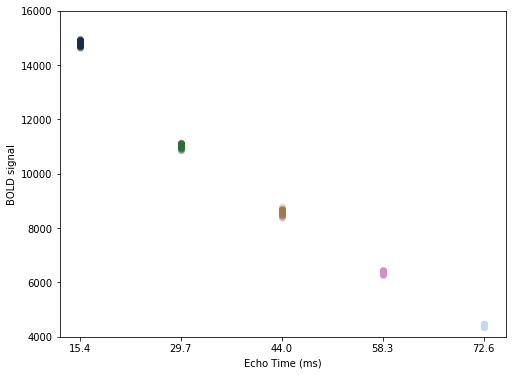

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel('BOLD signal')
ax.set_xlabel('Echo Time (ms)')
ax.set_xticks(echo_times)
ax.set_ylim(4000, 16000)
fig.show()

## Log-linear transformation

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


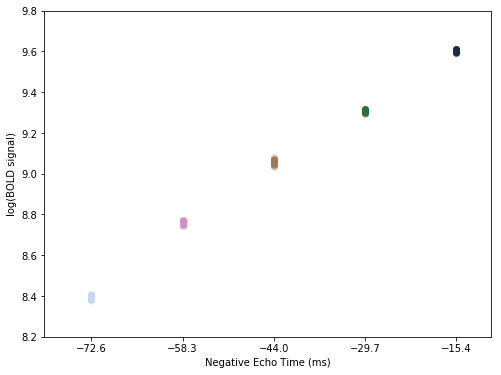

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.set_ylabel('log(BOLD signal)')
ax.set_xlabel('Negative Echo Time (ms)')
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-80, -10)
ax.set_ylim(8.2, 9.8)

fig.show()

## Log-linear model

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


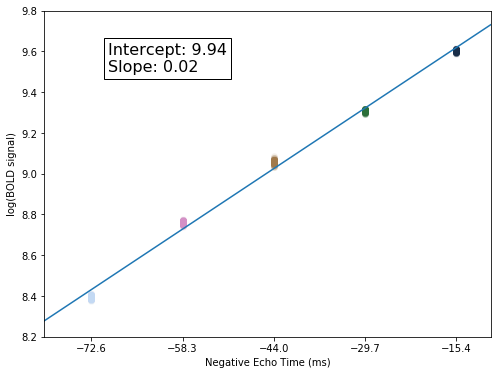

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.plot(log_x, log_y)

ax.set_ylabel('log(BOLD signal)')
ax.set_xlabel('Negative Echo Time (ms)')
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-80, -10)
ax.set_ylim(8.2, 9.8)

ax.annotate('Intercept: {0:.02f}\nSlope: {1:.02f}'.format(betas[0], betas[1]),
            xy=(-70, 9.5), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.show()

# Monoexponential decay model

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


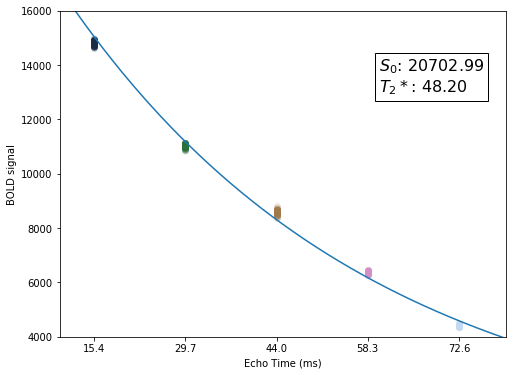

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.set_ylabel('BOLD signal')
ax.set_xlabel('Echo Time (ms)')
ax.set_xticks(echo_times)
ax.set_xlim(10, 80)
ax.set_ylim(4000, 16000)
ax.annotate('$S_0$: {0:.02f}\n$T_2*$: {1:.02f}'.format(s0, t2s),
            xy=(60, 13000), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.show()

## T2*

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


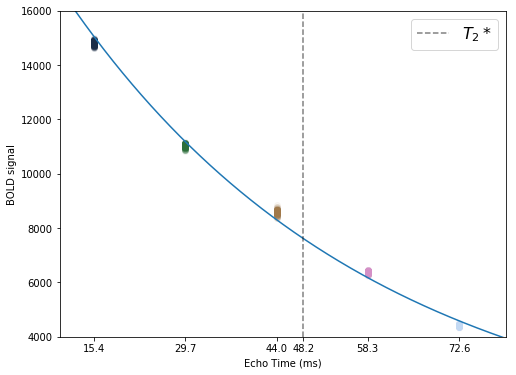

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.axvline(t2s, 0, 1, label='$T_2*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal')
ax.set_xlabel('Echo Time (ms)')
ax.set_xticks(np.hstack((echo_times, [t2s])))
ax.set_xlim(10, 80)
ax.set_ylim(4000, 16000)

legend = ax.legend(frameon=True, fontsize=16)

fig.show()

## Optimal combination weights

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


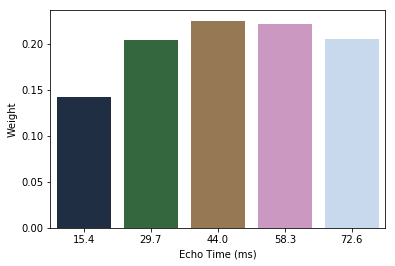

In [10]:
fig, ax = plt.subplots()
sns.barplot(echo_times, alpha, ax=ax, palette=pal)
ax.set_ylabel('Weight')
ax.set_xlabel('Echo Time (ms)')
fig.show()

## Optimally combined timeseries

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


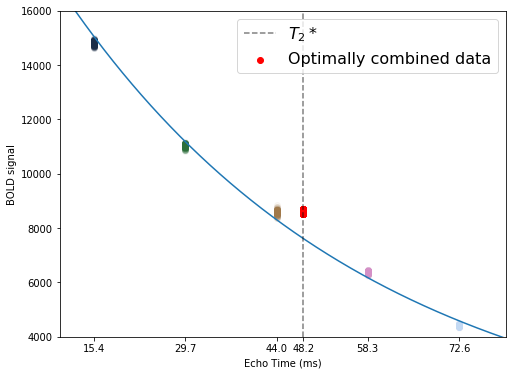

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

# Optimal combination
rep_t2s = np.ones(n_trs) * t2s
ax.scatter(rep_t2s, oc, alpha=1, color='red', label='Optimally combined data')

ax.axvline(t2s, 0, 20000, label='$T_2*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal')
ax.set_xlabel('Echo Time (ms)')
ax.set_xticks(np.hstack((echo_times, [t2s])))
ax.set_xlim(10, 80)
ax.set_ylim(4000, 16000)

legend = ax.legend(frameon=True, fontsize=16)

fig.show()

## Optimally combined timeseries

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


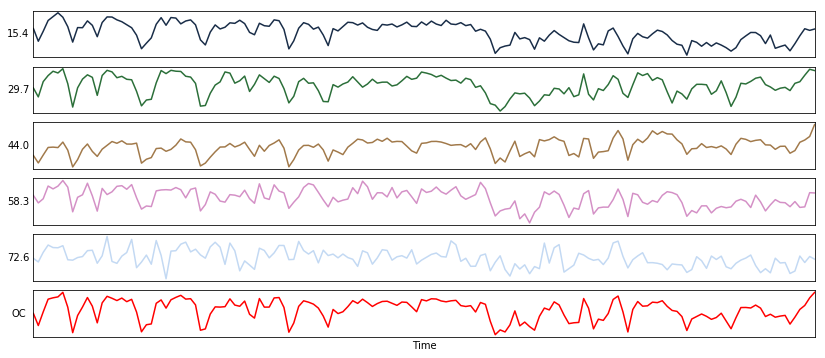

In [12]:
fig, axes = plt.subplots(n_echoes+1, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(echo_times[i_echo], rotation=0, va='center', labelpad=15)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].plot(oc, color='red')
axes[-1].set_ylabel('OC', rotation=0, va='center', labelpad=15)
axes[-1].set_xlabel('Time')
axes[-1].set_yticks([])
axes[-1].set_xticks([])
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.show()